## Contextualização

A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma fintech para desenvolver um projeto de concessão de crédito para veículos. Nesse projeto, espera-se a criação de valor que discrimine ao máximo os bons pagadores dos maus pagadores. Para isso, foi disponibilizada uma base de dados com mais de 185 mil casos de empréstimos do passado com diversas características dos clientes. Devem ser entregues um modelo. Por questões contratuais, o pagamento será realizado baseado no desempenho (gini) do modelo ao longo do tempo.

## Base de Dados

Será utilizada uma base de dados com informações cadastrais e histórico de crédito de clientes indianos. O conjunto de dados está dividido em treino e teste sem variável resposta, todos no formato pickle comprimido com gzip. Para leitura, basta executar df = pd.read_pickle('nome_do_arquivo.pkl.gz'). Toda a modelagem e validação deve ser feita em cima do conjunto de treino, subdividindo tal base como a squad achar melhor. Existe também os metadados das variáveis explicativas, para ajudar no desenvolvimento do projeto.

## Definições

### Nota

A nota final da squad será composta por:

Desempenho do modelo em uma base de label escondida (50 pontos), sendo avaliado o Gini.

A squad com melhor desempenho na base escondida receberá 50 pontos;

A squad com segundo melhor desempenho na base escondida receberá 45 pontos;

A squad com terceiro melhor desempenho na base escondida receberá 40 pontos;

A squad com quarto melhor desempenho na base escondida receberá 35 pontos;

Fluxo para decisão de qual modelo será efetivamente usado (50 pontos)

Serão avaliados todo o fluxo de modelagem, incluindo (mas não exclusivamente) pré-processamento, métricas, seleção de modelo (25 pontos);

Os fatos que levam a squad a decisão de escolha de um modelo final (15 pontos);

Motivos que levaram a squad a usar ou não usar determinadas variáveis (estamos simulando uma financeira, então pensem em questões de ética e imagem da empresa, por exemplo) (10 pontos).

### Regras de Entrega

Deve ser entregue uma base com as predições para a base de teste.

Essa base deverá ser um Data Frame com duas colunas: a primeira sendo o ID da pessoa (variável id_pessoa) e a segunda a probabilidade de inadimplência.

:warning: Entregar as predições com a probabilidade da inadimplência ocorrer.

Deve ser entregue um notebook com a análise exploratória e análise de modelagem, mostrando como as variáveis foram investigadas, as hipóteses levantas, o por quê das decisões.

Um vídeo de até 10 min fazendo o walk-through desse notebook (não se preocupem em criar a apresentação ou coisas do tipo, apenas gravem a tela do notebook explicando cada step).

Uma tabela-resumo com todos os modelos testados, as variáveis usadas nesse modelo e a métrica encontrada no treino e teste. Isso também pautará as decisões sobre qual modelo foi escolhido.

### Dicas

Explorar o conceito das variáveis: possui risco de imagem uma empresa utilizar variável de idade para determinar risco de crédito? Vale a pena trazer a variável para o modelo?

Criar novas variáveis usando as variáveis que já estão na base: criatividade tem que ser mato.

Conversar com Rychard para tirar dúvidas sobre o projeto.


In [2]:
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier


pd.set_option('display.max_columns', None)

In [3]:
treino = pd.read_pickle('treino.pkl')
teste = pd.read_pickle('teste_aluno.pkl')

# Pré-processamento

In [3]:
treino.columns

Index(['id_pessoa', 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo',
       'agencia', 'revendedora', 'montadora', 'Current_pincode_ID',
       'nascimento', 'emprego', 'data_contrato', 'estado', 'funcionario',
       'flag_telefone', 'flag_aadhar', 'flag_pan', 'flag_eleitor',
       'flag_cmotorista', 'flag_passaporte', 'score', 'score_desc',
       'pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def',
       'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom', 'sec_qtd_tot_emp',
       'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_san',
       'sec_emp_tom', 'par_pri_emp', 'par_seg_emp', 'nov_emp_6m', 'def_emp_6m',
       'tem_med_emp', 'tem_pri_emp', 'qtd_sol_emp', 'default'],
      dtype='object')

In [4]:
treino.head()

,id_pessoa,valor_emprestimo,custo_ativo,emprestimo_custo,agencia,revendedora,montadora,Current_pincode_ID,nascimento,emprego,data_contrato,estado,funcionario,flag_telefone,flag_aadhar,flag_pan,flag_eleitor,flag_cmotorista,flag_passaporte,score,score_desc,pri_qtd_tot_emp,pri_qtd_tot_emp_atv,pri_qtd_tot_def,pri_emp_abt,pri_emp_san,pri_emp_tom,sec_qtd_tot_emp,sec_qtd_tot_emp_atv,sec_qtd_tot_def,sec_emp_abt,sec_emp_san,sec_emp_tom,par_pri_emp,par_seg_emp,nov_emp_6m,def_emp_6m,tem_med_emp,tem_pri_emp,qtd_sol_emp,default
155653,487469,63418,75571,85.00,136,14189,86,3783,10-05-76,Salaried,03-09-18,8,2064,1,1,0,0,0,0,676,F-Low Risk,41,16,2,1365190,1454300,1454300,0,0,0,0,0,0,3746800,0,3,0,0yrs 8mon,5yrs 5mon,0,0
98628,627194,42494,69042,65.18,1,22056,45,4923,05-02-97,Self employed,26-10-18,3,1298,1,0,0,1,0,0,824,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1yrs 1mon,1yrs 1mon,0,0
132937,636647,56909,69407,84.86,5,17980,86,3396,06-05-83,Salaried,29-10-18,9,679,1,0,0,1,0,0,755,C-Very Low Risk,14,4,0,12162,97826,26664,0,0,0,0,0,0,0,0,4,0,0yrs 5mon,1yrs 4mon,0,0
29031,518430,69488,82782,85.00,19,14375,86,1838,07-01-83,Self employed,19-09-18,4,603,1,1,0,0,0,0,604,H-Medium Risk,5,2,0,68664,80000,80000,0,0,0,0,0,0,11840,0,2,0,1yrs 1mon,3yrs 1mon,7,0
67486,577759,54963,66783,84.90,74,22928,86,2578,01-01-94,Salaried,14-10-18,4,286,1,1,0,0,0,0,737,C-Very Low Risk,3,1,0,36654,57131,57131,0,0,0,0,0,0,2658,0,0,0,0yrs 10mon,1yrs 4mon,0,0


In [5]:
#prof = ProfileReport(treino)
#prof.to_file(output_file="output.html")

In [6]:
#Dropando as colunas que identicam os funcionarios. Bem como a origem do veículo
colunas_drop = ['agencia','funcionario','revendedora','montadora', "flag_telefone",'Current_pincode_ID',
                'flag_aadhar', 'flag_passaporte', 'estado']
treino.drop(colunas_drop, axis=1, inplace=True)
teste.drop(colunas_drop, axis=1, inplace=True)

In [7]:
# função para corrigir os anos (61 é considerado como 2061, por exemplo)
def corrige_anos(arr):
    
    '''
    Essa função recebe um array de datas no formato string, seleciona se o final dela (ano)
    for menor que 20 (referência a 2020) e então formata como ano com inicio 19 ou 20 
    
    '''
    
    lista = []
    for i in arr:
        if int(i[6:]) < 20:
            lista.append(i[:6]+'20'+i[6:])
        else:
            lista.append(i[:6]+'19'+i[6:])
    return lista

In [8]:
# Convertendo o ano com a função criada
treino.nascimento = corrige_anos(treino.nascimento)
teste.nascimento = corrige_anos(teste.nascimento)

In [9]:
#Convertendo o nascimento para anos 
now = pd.Timestamp('now')
treino['idade'] = (now - pd.to_datetime(treino.nascimento,format='%d-%m-%Y')).astype('<m8[Y]')
teste['idade'] = (now - pd.to_datetime(teste.nascimento,format='%d-%m-%Y')).astype('<m8[Y]')
treino.drop('nascimento', axis =1, inplace=True)
teste.drop('nascimento', axis =1, inplace=True)

In [10]:
#Convertendo a data do contrato para dias

now = pd.Timestamp('now')
treino['dias_contrato'] = (now - pd.to_datetime(treino.data_contrato,format='%d-%m-%y')).dt.days
teste['dias_contrato'] = (now - pd.to_datetime(teste.data_contrato,format='%d-%m-%y')).dt.days
treino.drop('data_contrato', axis =1, inplace=True)
teste.drop('data_contrato', axis =1, inplace=True)

In [11]:
treino.dias_contrato

155653    765
98628     712
132937    709
29031     749
67486     724
         ... 
158885    723
144610    734
204677    707
68304     776
57003     772
Name: dias_contrato, Length: 186523, dtype: int64

In [12]:
def str_para_mes(arr):
    
        
    '''
    Essa função recebe um array de datas no formato string: (5yrs 5mon). Retira a referência ao ano e ao mês e 
    retorna a soma entre os anos e meses como um array.    
    '''
    
    
    ano = []
    mes=[]
    arr = arr.str.replace('yrs ', '-').str.replace('mon','')
    for i in arr.index:
        ano.append(int(arr.loc[i].split('-')[0]))
        mes.append(int(arr.loc[i].split('-')[1]))


    return np.array(ano)*12+np.array(mes)
        


In [13]:
#Convertendo para mês
treino['tem_med_emp'] = str_para_mes(treino.tem_med_emp)
teste['tem_med_emp'] = str_para_mes(teste.tem_med_emp)

In [14]:
#Convertendo para mês
treino['tem_pri_emp'] = str_para_mes(treino.tem_pri_emp)
teste['tem_pri_emp'] = str_para_mes(teste.tem_pri_emp)

In [15]:
treino.columns

Index(['id_pessoa', 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo',
       'emprego', 'flag_pan', 'flag_eleitor', 'flag_cmotorista', 'score',
       'score_desc', 'pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv',
       'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom',
       'sec_qtd_tot_emp', 'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def',
       'sec_emp_abt', 'sec_emp_san', 'sec_emp_tom', 'par_pri_emp',
       'par_seg_emp', 'nov_emp_6m', 'def_emp_6m', 'tem_med_emp', 'tem_pri_emp',
       'qtd_sol_emp', 'default', 'idade', 'dias_contrato'],
      dtype='object')

In [16]:
#Retirando a variável resposta e a id para o preprocessamento
treino_exp= treino.drop(['default', 'id_pessoa'], axis=1)

In [17]:
numericas = ['valor_emprestimo', 'custo_ativo', 'emprestimo_custo',
        'score',  'pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv',
       'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san', 'pri_emp_tom',
       'sec_qtd_tot_emp', 'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def',
       'sec_emp_abt', 'sec_emp_san', 'sec_emp_tom', 'par_pri_emp',
       'par_seg_emp', 'nov_emp_6m', 'def_emp_6m', 'tem_med_emp', 'tem_pri_emp',
       'qtd_sol_emp', 'idade', 'dias_contrato']

In [18]:
treino_exp[numericas] = treino_exp[numericas].astype(float)

In [19]:
categoricas = ['emprego', 'flag_pan', 'flag_eleitor', 'flag_cmotorista',
       'score_desc']

In [20]:
#Pipeline para o pré-processmento

pipe_num = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'median' )),
    ('minmax', StandardScaler())
])

pipe_cat = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OrdinalEncoder())
])

preproc = ColumnTransformer(transformers = [
    ('proc_cat', pipe_cat, categoricas),
    ('proc_num', pipe_num, numericas)
    
], n_jobs=-1)

pipe_final = Pipeline([
    ('proc', preproc),
])


In [21]:
treino_trans= pipe_final.fit_transform(treino_exp)

In [22]:
#Lista de colunas para renomear o DF
col = treino.columns.drop(['id_pessoa', 'default'])

In [23]:
# Transformando o array em DF
treino_trans = pd.DataFrame(treino_trans, columns = col)

In [24]:
treino_trans.head()

,valor_emprestimo,custo_ativo,emprestimo_custo,emprego,flag_pan,flag_eleitor,flag_cmotorista,score,score_desc,pri_qtd_tot_emp,pri_qtd_tot_emp_atv,pri_qtd_tot_def,pri_emp_abt,pri_emp_san,pri_emp_tom,sec_qtd_tot_emp,sec_qtd_tot_emp_atv,sec_qtd_tot_def,sec_emp_abt,sec_emp_san,sec_emp_tom,par_pri_emp,par_seg_emp,nov_emp_6m,def_emp_6m,tem_med_emp,tem_pri_emp,qtd_sol_emp,idade,dias_contrato
0,0.0,0.0,0.0,0.0,5.0,0.695888,-0.014865,0.896406,1.143995,7.355630,7.701951,3.378889,1.239846,0.474298,0.473869,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,23.066048,-0.020723,2.733819,-0.252859,-0.060290,1.703065,-0.293772,0.817909,0.745265
1,1.0,0.0,1.0,0.0,0.0,-0.910495,-0.357413,-0.837566,1.581459,-0.273514,-0.533376,-0.285939,-0.171842,-0.084420,-0.084163,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,0.269995,-0.113055,-0.293772,-1.319733,-1.191987
2,0.0,0.0,1.0,0.0,2.0,0.196177,-0.338263,0.884158,1.377506,2.205958,1.525456,-0.285939,-0.159266,-0.046837,-0.073932,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,3.777862,-0.252859,-0.258461,-0.008279,-0.293772,0.105362,-1.301643
3,1.0,0.0,0.0,0.0,7.0,1.161896,0.363464,0.896406,0.931175,0.489400,0.496040,-0.285939,-0.100839,-0.053686,-0.053466,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.009530,-0.020723,1.689776,-0.252859,0.269995,0.725154,9.681440,0.105362,0.160434
4,0.0,0.0,0.0,0.0,2.0,0.046779,-0.475933,0.887657,1.324301,0.107943,-0.018668,-0.285939,-0.133940,-0.062472,-0.062241,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.066259,-0.020723,-0.398311,-0.252859,0.071824,-0.008279,-0.293772,-1.014356,-0.753364


In [25]:
#Reinserindo as colunas de id e resposta
treino_trans.insert(0, column='id_pessoa' , value=treino.id_pessoa.values)


In [26]:
treino_trans.insert(1, column='default' , value=treino.default.values)

In [27]:
treino_trans.head()

,id_pessoa,default,valor_emprestimo,custo_ativo,emprestimo_custo,emprego,flag_pan,flag_eleitor,flag_cmotorista,score,score_desc,pri_qtd_tot_emp,pri_qtd_tot_emp_atv,pri_qtd_tot_def,pri_emp_abt,pri_emp_san,pri_emp_tom,sec_qtd_tot_emp,sec_qtd_tot_emp_atv,sec_qtd_tot_def,sec_emp_abt,sec_emp_san,sec_emp_tom,par_pri_emp,par_seg_emp,nov_emp_6m,def_emp_6m,tem_med_emp,tem_pri_emp,qtd_sol_emp,idade,dias_contrato
0,487469,0,0.0,0.0,0.0,0.0,5.0,0.695888,-0.014865,0.896406,1.143995,7.355630,7.701951,3.378889,1.239846,0.474298,0.473869,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,23.066048,-0.020723,2.733819,-0.252859,-0.060290,1.703065,-0.293772,0.817909,0.745265
1,627194,0,1.0,0.0,1.0,0.0,0.0,-0.910495,-0.357413,-0.837566,1.581459,-0.273514,-0.533376,-0.285939,-0.171842,-0.084420,-0.084163,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,0.269995,-0.113055,-0.293772,-1.319733,-1.191987
2,636647,0,0.0,0.0,1.0,0.0,2.0,0.196177,-0.338263,0.884158,1.377506,2.205958,1.525456,-0.285939,-0.159266,-0.046837,-0.073932,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,3.777862,-0.252859,-0.258461,-0.008279,-0.293772,0.105362,-1.301643
3,518430,0,1.0,0.0,0.0,0.0,7.0,1.161896,0.363464,0.896406,0.931175,0.489400,0.496040,-0.285939,-0.100839,-0.053686,-0.053466,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.009530,-0.020723,1.689776,-0.252859,0.269995,0.725154,9.681440,0.105362,0.160434
4,577759,0,0.0,0.0,0.0,0.0,2.0,0.046779,-0.475933,0.887657,1.324301,0.107943,-0.018668,-0.285939,-0.133940,-0.062472,-0.062241,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.066259,-0.020723,-0.398311,-0.252859,0.071824,-0.008279,-0.293772,-1.014356,-0.753364


### Os mesmos passos do treino no dataframe de teste

In [28]:
teste_exp = teste.drop(['id_pessoa'], axis=1)

In [29]:
teste_exp = pipe_final.transform(teste_exp)

In [30]:
col = teste.columns.drop(['id_pessoa'])

In [31]:
teste_trans = pd.DataFrame(teste_exp, columns = col)

In [32]:
teste_trans.insert(0, column='id_pessoa' , value=teste.id_pessoa.values)

In [33]:
teste_trans.head()

,id_pessoa,valor_emprestimo,custo_ativo,emprestimo_custo,emprego,flag_pan,flag_eleitor,flag_cmotorista,score,score_desc,pri_qtd_tot_emp,pri_qtd_tot_emp_atv,pri_qtd_tot_def,pri_emp_abt,pri_emp_san,pri_emp_tom,sec_qtd_tot_emp,sec_qtd_tot_emp_atv,sec_qtd_tot_def,sec_emp_abt,sec_emp_san,sec_emp_tom,par_pri_emp,par_seg_emp,nov_emp_6m,def_emp_6m,tem_med_emp,tem_pri_emp,qtd_sol_emp,idade,dias_contrato
0,563819,1.0,0.0,1.0,0.0,13.0,-0.515041,0.170443,-1.009914,-0.854152,-0.464243,-0.533376,-0.285939,-0.171842,-0.084420,-0.084163,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,-0.588745,-0.567085,-0.293772,0.919701,-0.534052
1,482578,0.0,0.0,0.0,0.0,17.0,-0.923546,-0.712447,-0.077313,-0.803903,-0.273514,-0.018668,-0.285939,-0.124275,-0.066748,-0.066512,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,0.645732,-0.252859,-0.588745,-0.567085,-0.293772,-1.116148,0.854921
2,565578,1.0,0.0,0.0,0.0,1.0,2.582259,2.287795,-0.022197,1.401153,-0.273514,-0.018668,-0.285939,-0.171842,-0.074432,-0.074187,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,0.468165,-0.008279,-0.293772,-0.200016,-0.570604
3,629237,1.0,0.0,0.0,0.0,13.0,0.299820,0.238491,-0.010824,-0.854152,-0.464243,-0.533376,-0.285939,-0.171842,-0.084420,-0.084163,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,-0.588745,-0.567085,-0.293772,-0.403601,-1.228539
4,485542,1.0,0.0,0.0,0.0,13.0,0.945475,1.212776,-0.528741,-0.854152,-0.464243,-0.533376,-0.285939,-0.171842,-0.084420,-0.084163,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,-0.588745,-0.567085,-0.293772,-0.912563,0.854921


In [34]:
teste_trans.shape

(46631, 31)

In [35]:
teste_trans.to_csv('teste_trans.csv')

In [36]:
treino_trans.to_csv('treino_trans.csv')

# Criação dos modelos

In [3]:
treino_explicativo = pd.read_csv("treino_trans.csv", index_col=0)
treino_resposta = treino_explicativo["default"]
treino_explicativo = treino_explicativo.drop(["default"], axis = 1)
teste = pd.read_csv("teste_trans.csv", index_col=0)

In [46]:
teste.head()

,id_pessoa,valor_emprestimo,custo_ativo,emprestimo_custo,emprego,flag_pan,flag_eleitor,flag_cmotorista,score,score_desc,pri_qtd_tot_emp,pri_qtd_tot_emp_atv,pri_qtd_tot_def,pri_emp_abt,pri_emp_san,pri_emp_tom,sec_qtd_tot_emp,sec_qtd_tot_emp_atv,sec_qtd_tot_def,sec_emp_abt,sec_emp_san,sec_emp_tom,par_pri_emp,par_seg_emp,nov_emp_6m,def_emp_6m,tem_med_emp,tem_pri_emp,qtd_sol_emp,idade,dias_contrato
0,563819,1.0,0.0,1.0,0.0,13.0,-0.515041,0.170443,-1.009914,-0.854152,-0.464243,-0.533376,-0.285939,-0.171842,-0.084420,-0.084163,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,-0.588745,-0.567085,-0.293772,0.919701,-0.534052
1,482578,0.0,0.0,0.0,0.0,17.0,-0.923546,-0.712447,-0.077313,-0.803903,-0.273514,-0.018668,-0.285939,-0.124275,-0.066748,-0.066512,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,0.645732,-0.252859,-0.588745,-0.567085,-0.293772,-1.116148,0.854921
2,565578,1.0,0.0,0.0,0.0,1.0,2.582259,2.287795,-0.022197,1.401153,-0.273514,-0.018668,-0.285939,-0.171842,-0.074432,-0.074187,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,0.468165,-0.008279,-0.293772,-0.200016,-0.570604
3,629237,1.0,0.0,0.0,0.0,13.0,0.299820,0.238491,-0.010824,-0.854152,-0.464243,-0.533376,-0.285939,-0.171842,-0.084420,-0.084163,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,-0.588745,-0.567085,-0.293772,-0.403601,-1.228539
4,485542,1.0,0.0,0.0,0.0,13.0,0.945475,1.212776,-0.528741,-0.854152,-0.464243,-0.533376,-0.285939,-0.171842,-0.084420,-0.084163,-0.092825,-0.087249,-0.065345,-0.031474,-0.03946,-0.038971,-0.082681,-0.020723,-0.398311,-0.252859,-0.588745,-0.567085,-0.293772,-0.912563,0.854921


## Regressão logística

In [5]:
modelo = LogisticRegression(random_state = 123)


rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'penalty' : ['l1', '12', 'elasticnet', 'none'],
                                                 'C': np.arange(1, 50),
                                                 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],},
                          scoring = 'roc_auc',
                          cv = 5,
                          n_jobs= 4,
                          refit = True,
                          verbose = 1,
                          n_iter = 1000)

In [6]:
rscv.fit(treino_explicativo, treino_resposta)

C:\Users\eppmi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 784 is smaller than n_iter=1000. Running 784 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 784 candidates, totalling 3920 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 13.5min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 25.5min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 38.9min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 57.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 81.2min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 104.8min
[Parallel(n_jobs=4)]: Done 3920 out of 3920 | elapsed: 126.9min finished
C:\Users\eppmi\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\eppmi\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\epp

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=123),
                   n_iter=1000, n_jobs=4,
                   param_distributions={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'penalty': ['l1', '12', 'elasticnet',
                                                    'none'],
                                        'solver': ['newton-cg', 'lbfgs', 'sag',
                                                   'saga']},
                   scoring='roc_auc', verbose=1)

In [7]:
rscv.best_params_

{'solver': 'newton-cg', 'penalty': 'none', 'C': 1}

In [8]:
y_teste_pred = rscv.predict_proba(treino_explicativo)

In [9]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.6290246390899086

## Random forest

In [10]:
modelo = RandomForestClassifier(n_estimators = 100,
                                max_depth=5,
                                max_samples = 10,
                                n_jobs = -1) 



In [11]:
modelo.fit(treino_explicativo, treino_resposta)

RandomForestClassifier(max_depth=5, max_samples=10, n_jobs=-1)

In [12]:
y_teste_pred = modelo.predict_proba(treino_explicativo)

In [13]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.5533905198782701

In [4]:
modelo = RandomForestClassifier() 


rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'n_estimators': np.arange(100, 1000, 100),
                                                 'max_samples': np.arange(1, 5),
                                                 'max_depth': np.arange(3,5),
                                                 
                                                 'criterion': ['gini', 'entropy'],
                                                 'max_leaf_nodes': np.arange(0, 50),
                                                 'min_samples_split': np.arange(2, 50),
                                                 'n_jobs': [4],
                                                 'class_weight' : ['balanced', 'balanced_subsample', 'None'],
                                                 'min_impurity_decrease': np.arange(0, 1, 0.001)},
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = 1,
                            n_jobs = 4,
                          n_iter = 100)

In [5]:
rscv.fit(treino_explicativo, treino_resposta)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 10.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 23.5min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 25.6min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=4,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         'None'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([3, 4]),
                                        'max_leaf_nodes': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 4...
       0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989,
       0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
  

In [6]:
rscv.best_params_

{'n_jobs': 4,
 'n_estimators': 700,
 'min_samples_split': 25,
 'min_impurity_decrease': 0.509,
 'max_samples': 2,
 'max_leaf_nodes': 36,
 'max_depth': 4,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [7]:
y_teste_pred = rscv.predict_proba(treino_explicativo)

In [8]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.5

### Arvores

In [20]:
modelo = DecisionTreeClassifier()
rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'max_depth': np.arange(1, 20), 
                                                 'criterion': ['gini', 'entropy'],
                                                 'min_samples_leaf': np.arange(1, 50),
                                                 'min_samples_split': np.arange(2, 50),
                                                 'min_impurity_decrease': np.arange(0, 1, 0.001)},
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = 1,
                            n_jobs = 5,
                          n_iter = 1440)

In [21]:
rscv.fit(treino_explicativo, treino_resposta)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   20.4s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   52.4s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  4.6min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed:  5.9min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed:  9.0min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 10.8min
[Parallel(n_jobs=5)]: Done 7190 tasks      | elapsed: 12.8min
[Parallel(n_jobs=5)]: Done 7200 out of 7200 | elapsed: 12.9min finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=1440,
                   n_jobs=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0....
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 

In [22]:
rscv.best_params_

{'min_samples_split': 34,
 'min_samples_leaf': 22,
 'min_impurity_decrease': 0.0,
 'max_depth': 7,
 'criterion': 'entropy'}

In [23]:
y_teste_pred = rscv.predict_proba(treino_explicativo)

In [24]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.6315743808039911

### Tree Regressor

In [25]:
modelo = DecisionTreeRegressor()
rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'max_depth': np.arange(1, 20), 
                                                 'criterion': ['mse', 'friedman_mse', 'mae'],
                                                 'min_samples_leaf': np.arange(1, 50),
                                                 'min_samples_split': np.arange(2, 50),
                                                 'min_impurity_decrease': np.arange(0, 1, 0.01)},
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = 1,
                            n_jobs = 4,
                          n_iter = 10)

In [26]:
rscv.fit(treino_explicativo, treino_resposta)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 154.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 217.4min finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=4,
                   param_distributions={'criterion': ['mse', 'friedman_mse',
                                                      'mae'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_impurity_decrease': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24,...
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 

In [27]:
rscv.best_params_

{'min_samples_split': 36,
 'min_samples_leaf': 19,
 'min_impurity_decrease': 0.74,
 'max_depth': 3,
 'criterion': 'friedman_mse'}

In [28]:
y_teste_pred = rscv.predict(treino_explicativo)

In [29]:
roc_auc_score(treino_resposta, y_teste_pred)

0.6003817688715436

### SVM

In [ ]:
modelo = SVC()


rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'C': np.arange(1, 50),
                                                 'kernel':['linear', 'poly', 'rbf', 'sigmoid'],                                                 
                                                 'gamma': ['scale', 'auto'],
                                                'shrinking':['True', "False"],
                                                'probability': ["True"],
                                                'decision_function_shape': ['ovo', 'ovr'],
                                                'break_ties': ['True','False']},
                          scoring = 'roc_auc',
                          cv = 5,
                          n_jobs= 4,
                          refit = True,
                          verbose = 1,
                          n_iter = 100)

In [ ]:
base = SVC()
modelo = BaggingClassifier(base_estimator = base,
                           n_estimators = 10,
                           max_samples = 0.6,
                           bootstrap = False)
modelo.fit(treino_explicativo, treino_resposta)

In [ ]:
y_teste_pred = rscv.predict_proba(treino_explicativo)
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

In [4]:
modelo = SVC(probability = True,)

In [5]:
modelo.fit(treino_explicativo, treino_resposta)

SVC(probability=True)

In [6]:
y_teste_pred = modelo.predict_proba(treino_explicativo)

In [7]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.4655817728573386

In [ ]:
pipe_num = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'median')),
    ('minmax', MinMaxScaler())
])

pipe_cat = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OrdinalEncoder())
])

preproc = ColumnTransformer(transformers = [
    ('proc_num', pipe_num, numericas),
    ('proc_cat', pipe_cat, ['emprego', 'score_desc'])
])

pipe_final = Pipeline([
    ('proc', preproc),
    ('modelo', LogisticRegression())
])


In [ ]:
pipe_final.fit(treino_exp, treino_resp)

In [ ]:
lr = LogisticRegression()

In [ ]:
treino_trans.columns

In [ ]:
x_treino = treino_trans.drop('default', axis=1)
y_treino = treino_trans['default']

In [ ]:
lr.fit(x_treino,y_treino)

In [ ]:
y_pred = lr.predict(x_treino)

In [ ]:
accuracy_score(y_treino,y_pred)

# Separação

In [5]:
from sklearn.decomposition import PCA

In [6]:


pca = PCA(n_components=4)
pca.fit(treino_explicativo)
print(pca.explained_variance_ratio_)

[9.99999989e-01 5.87682186e-09 8.32762919e-10 7.01990483e-10]


In [7]:
treino_pca = pca.transform(treino_explicativo)
teste_pca = pca.transform(teste)

In [19]:
treino_pca.shape

(186523, 4)

In [20]:
modelo = SVC()


rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'C': np.arange(1, 50),
                                                 'kernel':['linear', 'rbf', 'sigmoid'],                                                 
                                                 'gamma': ['scale', 'auto'],
                                                'shrinking':['True', "False"],
                                                'probability': ["True"],
                                                'decision_function_shape': ['ovo', 'ovr'],
                                                'break_ties': ['True','False']},
                          scoring = 'roc_auc',
                          cv = 5,
                          n_jobs= -1,
                          refit = True,
                          verbose = 1,
                          n_iter = 100)

In [ ]:
rscv = SVC(probability=True)
rscv.fit(treino_pca, treino_resposta)

In [35]:
y_teste_pred = rscv.predict_proba(treino_pca)

In [36]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.5194567039611498

In [8]:
modelo = RandomForestClassifier(n_estimators = 100,
                                max_depth=5,
                                max_samples = 10,
                                n_jobs = -1) 



In [9]:
modelo.fit(treino_pca, treino_resposta)

RandomForestClassifier(max_depth=5, max_samples=10, n_jobs=-1)

In [10]:
y_teste_pred = modelo.predict_proba(treino_pca)

In [11]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.5257018177853641

In [12]:
modelo = DecisionTreeClassifier()
rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'max_depth': np.arange(1, 20), 
                                                 'criterion': ['gini', 'entropy'],
                                                 'min_samples_leaf': np.arange(1, 50),
                                                 'min_samples_split': np.arange(2, 50),
                                                 'min_impurity_decrease': np.arange(0, 1, 0.001)},
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = 1,
                            n_jobs = -1,
                          n_iter = 1440)

In [13]:
rscv.fit(treino_pca, treino_resposta)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:  5.2min finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=1440,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0...
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 

In [14]:
rscv.best_params_

{'min_samples_split': 44,
 'min_samples_leaf': 8,
 'min_impurity_decrease': 0.0,
 'max_depth': 6,
 'criterion': 'entropy'}

In [15]:
y_teste_pred = rscv.predict_proba(treino_pca)

In [16]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.5919920477778472

# Adaboost

In [56]:
from sklearn.ensemble import AdaBoostClassifier

In [58]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split = 34,
 min_samples_leaf = 22,
 min_impurity_decrease = 0.0,
 max_depth = 7,
 criterion = 'entropy'), n_estimators=100)

In [60]:
clf.fit(treino_explicativo, treino_resposta)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=7,
                                                         min_samples_leaf=22,
                                                         min_samples_split=34),
                   n_estimators=100)

In [61]:
y_teste_pred = clf.predict_proba(treino_explicativo)

In [62]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.7731051228498657

In [63]:
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_jobs = -1,
 n_estimators = 200,
 min_samples_split = 2,
 min_impurity_decrease = 0.234,
 max_samples = 4,
 max_leaf_nodes = 15,
 max_depth = 4,
 criterion = 'entropy',
 class_weight = 'balanced'), n_estimators=100)

In [64]:
clf.fit(treino_explicativo, treino_resposta)

AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                         criterion='entropy',
                                                         max_depth=4,
                                                         max_leaf_nodes=15,
                                                         max_samples=4,
                                                         min_impurity_decrease=0.234,
                                                         n_estimators=200,
                                                         n_jobs=-1),
                   n_estimators=100)

In [65]:
y_teste_pred = clf.predict_proba(treino_explicativo)

In [66]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.5422109785139895

In [18]:
corr = treino_explicativo.corr().abs()


In [19]:
# Select upper triangle of correlation matrix
upper = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))

In [20]:
top = upper[upper > 0.8]

In [21]:
top

sec_emp_san      sec_emp_tom            0.999679
pri_emp_san      pri_emp_tom            0.998797
id_pessoa        dias_contrato          0.993194
flag_pan         score_desc             0.949393
sec_emp_abt      sec_emp_tom            0.929429
                 sec_emp_san            0.928639
tem_med_emp      tem_pri_emp            0.831254
sec_qtd_tot_emp  sec_qtd_tot_emp_atv    0.829059
dtype: float64

Text(0, 0.5, 'cumulative explained variance')

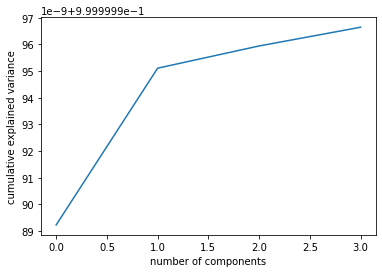

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [36]:
#Correlation with output variable

df = treino_explicativo
df["default"] = treino_resposta
cor = df.corr()
cor_target = abs(cor["default"])#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

default    1.0
Name: default, dtype: float64

In [39]:
cor_target.sort_values(ascending=False)

default                1.000000
score                  0.097095
flag_eleitor           0.075991
flag_pan               0.071287
score_desc             0.058982
qtd_sol_emp            0.044422
tem_pri_emp            0.042799
pri_qtd_tot_def        0.041481
pri_qtd_tot_emp_atv    0.041252
emprestimo_custo       0.040813
idade                  0.035524
def_emp_6m             0.035229
pri_qtd_tot_emp        0.034723
id_pessoa              0.031864
nov_emp_6m             0.029081
valor_emprestimo       0.026955
tem_med_emp            0.026421
pri_emp_abt            0.026016
dias_contrato          0.025934
flag_cmotorista        0.013679
par_pri_emp            0.010090
pri_emp_san            0.009322
sec_qtd_tot_emp        0.009307
pri_emp_tom            0.009182
sec_emp_san            0.006843
sec_emp_tom            0.006736
sec_qtd_tot_emp_atv    0.006551
sec_emp_abt            0.006056
emprego                0.004613
custo_ativo            0.002657
par_seg_emp            0.001565
sec_qtd_

In [12]:
selecionados = treino_explicativo[["flag_eleitor", "flag_pan","score_desc","qtd_sol_emp",
                                  "tem_pri_emp","pri_qtd_tot_def","pri_qtd_tot_emp_atv",
                                  "emprestimo_custo","idade","def_emp_6m","pri_qtd_tot_emp",
                                  "id_pessoa","nov_emp_6m","valor_emprestimo","tem_med_emp",
                                  "pri_emp_abt","dias_contrato","flag_cmotorista","par_pri_emp"]]

In [13]:
modelo = RandomForestClassifier() 


rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'n_estimators': np.arange(100, 1000, 100),
                                                 'max_samples': np.arange(1, 5),
                                                 'max_depth': np.arange(3,5),
                                                 
                                                 'criterion': ['gini', 'entropy'],
                                                 'max_leaf_nodes': np.arange(0, 50),
                                                 'min_samples_split': np.arange(2, 50),
                                                 'n_jobs': [-1],
                                                 'class_weight' : ['balanced', 'balanced_subsample', 'None'],
                                                 'min_impurity_decrease': np.arange(0, 1, 0.001)},
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = 1,
                            n_jobs = 5,
                          n_iter = 100)


In [14]:
rscv.fit(selecionados, treino_resposta)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  8.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 19.7min
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed: 21.8min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=5,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         'None'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': array([3, 4]),
                                        'max_leaf_nodes': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 4...
       0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989,
       0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
  

In [16]:
y_teste_pred = rscv.predict(selecionados)

roc_auc_score(treino_resposta, y_teste_pred)

0.5

4009

In [18]:
modelo = DecisionTreeClassifier()
rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'max_depth': np.arange(1, 20), 
                                                 'criterion': ['gini', 'entropy'],
                                                 'min_samples_leaf': np.arange(1, 50),
                                                 'min_samples_split': np.arange(2, 50),
                                                 'min_impurity_decrease': np.arange(0, 1, 0.001)},
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = 1,
                            n_jobs = 5,
                          n_iter = 1440)








In [19]:
rscv.fit(selecionados, treino_resposta)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   17.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   43.6s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  4.1min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed:  7.1min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed:  8.9min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 11.5min
[Parallel(n_jobs=5)]: Done 7190 tasks      | elapsed: 14.5min
[Parallel(n_jobs=5)]: Done 7200 out of 7200 | elapsed: 14.6min finished


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=1440,
                   n_jobs=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_impurity_decrease': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0....
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 

In [24]:
rscv.best_params_

{'min_samples_split': 13,
 'min_samples_leaf': 44,
 'min_impurity_decrease': 0.0,
 'max_depth': 5,
 'criterion': 'entropy'}

In [20]:
y_teste_pred = rscv.predict_proba(selecionados)

In [21]:
roc_auc_score(treino_resposta, y_teste_pred[:, 1])

0.610088477027986

# Gradient Boost

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

In [32]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate = learning_rate, random_state = 0)
    gb.fit(treino_explicativo, treino_resposta)
    print("Learning rate: ", learning_rate)
    y_teste_pred = gb.predict_proba(treino_explicativo)
    print("Roc_Auc Score: {0:.3f}".format(roc_auc_score(treino_resposta, y_teste_pred[:, 1])))







Learning rate:  0.05
Roc_Auc Score: 0.644
Learning rate:  0.1
Roc_Auc Score: 0.651
Learning rate:  0.25
Roc_Auc Score: 0.661
Learning rate:  0.5
Roc_Auc Score: 0.666
Learning rate:  0.75
Roc_Auc Score: 0.670
Learning rate:  1
Roc_Auc Score: 0.672


In [35]:
modelo = GradientBoostingClassifier() 


rscv = RandomizedSearchCV(estimator = modelo,
                          param_distributions = {'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
                                                 'max_depth': np.arange(3, 10,1),
                                                "max_features" : ['auto', 'sqrt', 'log2', None],
                                                 },
                          scoring = 'roc_auc',
                          cv = 5,
                          refit = True,
                          verbose = 1,
                            n_jobs = 5,
                          n_iter = 100)



In [37]:
rscv.fit(treino_explicativo, treino_resposta)

y_teste_pred = rscv.predict_proba(treino_explicativo)

roc_auc_score(treino_resposta, y_teste_pred[:, 1])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 28.0min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 108.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 217.2min
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed: 237.1min finished


0.7073408909506756

In [38]:
rscv.best_params_

{'max_features': 'log2', 'max_depth': 8, 'learning_rate': 0.05}